### EDA: Train Data

In [1]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

2023-11-29 01:31:44.541613: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 01:31:44.590758: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 01:31:44.591738: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 01:31:45.414630: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train = pd.read_csv('train_data.csv')

In [3]:
train.head()

,area,region,sub-region,year,urban_population,mei,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,...,cum_sum_log_drained_organic_soils_co2,cum_sum_log_net_forest_conversion,cum_sum_log_fires,cum_sum_log_manure_mgmt,cum_sum_log_food_systems,cum_sum_log_ippu_tot,cum_sum_log_on_farm_energy_use,cum_sum_forestland,cum_sum_total_emission,average_temperature_°c
0,Afghanistan,Asia,Southern Asia,1990,-0.248427,0.2,-0.207344,-0.200288,-0.241248,0.216313,...,-0.726651,-0.863273,-0.803507,-1.341128,-1.518110,-1.579650,-1.217366,0.228626,-0.283573,0.536167
1,Albania,Europe,Southern Europe,1990,-0.270189,0.2,-0.250166,-0.234801,-0.234608,0.245278,...,-0.650712,-0.863273,-0.806118,-1.353112,-1.528564,-1.554559,-1.275860,0.230803,-0.283139,0.735750
2,Algeria,Africa,Northern Africa,1990,-0.078775,0.2,-0.219436,-0.235802,-0.241248,0.243113,...,-0.726651,-0.772093,-0.764806,-1.337138,-1.481105,-1.529818,-1.293127,0.230641,-0.276729,1.005583
3,Andorra,Europe,Southern Europe,1990,-0.287987,0.2,-0.132015,-0.187767,-0.241248,0.244421,...,-0.726651,-0.863273,-0.851537,-1.325553,-1.530632,-1.547863,-1.304697,0.230739,-0.282425,1.278500
4,Angola,Africa,Sub-Saharan Africa,1990,-0.218440,0.2,-0.258033,-0.234738,-0.220441,0.244421,...,-0.632413,-0.734895,-0.661346,-1.344838,-1.512544,-1.565645,-1.320237,0.230739,-0.260562,0.676667


### Histogram of average temperature changes

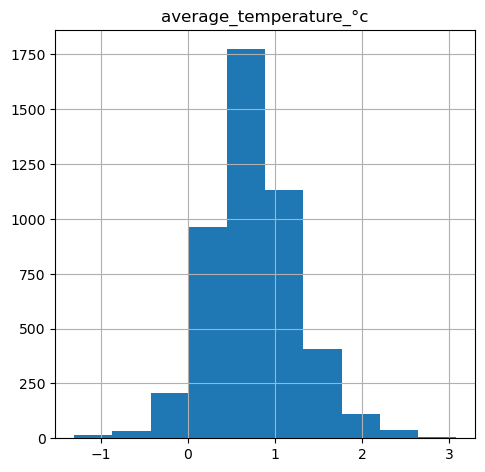

In [20]:
vars = [
'average_temperature_°c']

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(18,18))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(train, vars, 4,4)

### Correlation Matrix

Average Temperature Change is highly correlated with year and MEI. Little correlation with yearly agricultural emissions. 

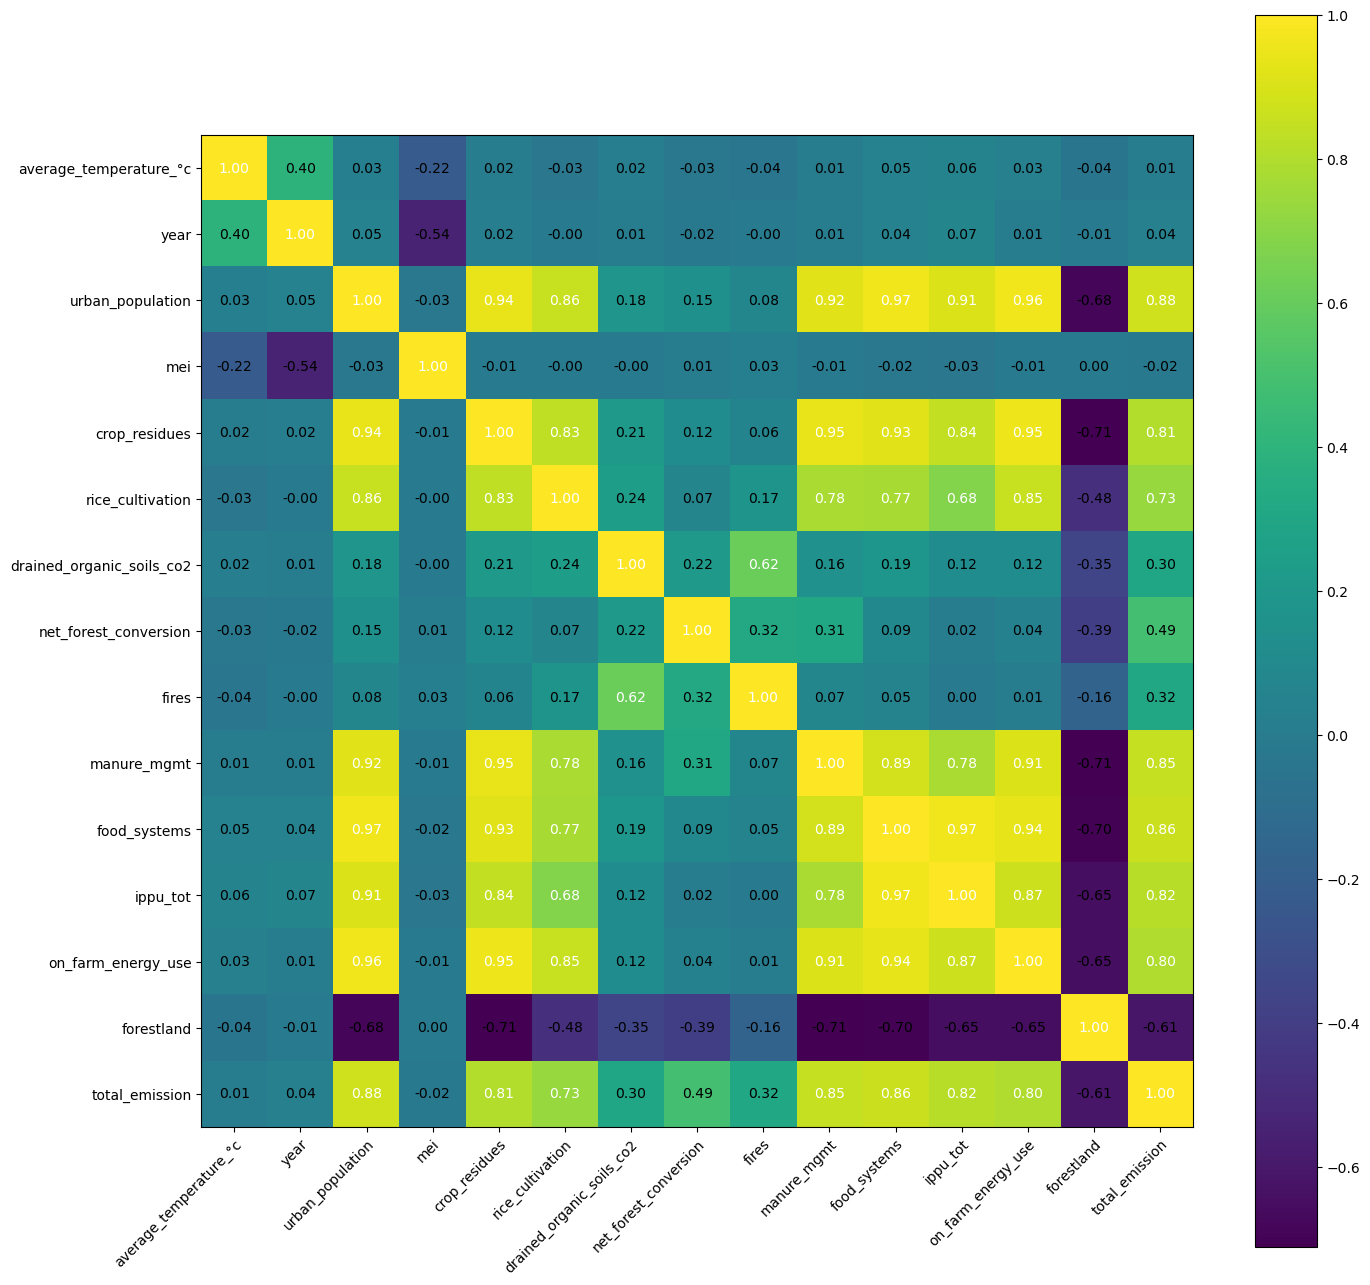

In [7]:
cols = ['average_temperature_°c','year','urban_population','mei','crop_residues','rice_cultivation',
        'drained_organic_soils_co2','net_forest_conversion','fires','manure_mgmt','food_systems','ippu_tot',
        'on_farm_energy_use','forestland','total_emission']
cm = train[cols].corr().values
hm = heatmap(
    cm,
    row_names=cols,
    column_names=cols,
    figsize=(16, 16)
)

### Compare correlation to temperature between yearly emissions, log, and cumulative sum of CO2 emissions

#### Crop Residue

Cumulative sum of log of crop residue emissions has highest correlation with average temperature change. 

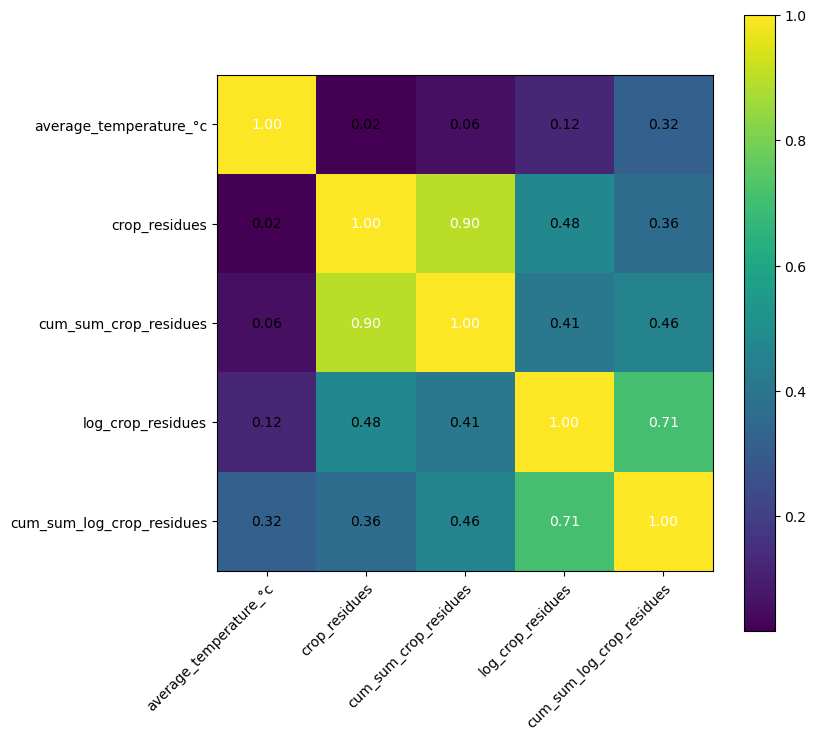

In [8]:
cols = ['average_temperature_°c','crop_residues', 'cum_sum_crop_residues', 'log_crop_residues','cum_sum_log_crop_residues']

cm = train[cols].corr().values
hm = heatmap(
    cm,
    row_names=cols,
    column_names=cols,
    figsize=(8, 8)
)

#### Rice Cultivation

Cumulative sum of log of rice cultivation emissions has highest correlation with average temperature change. 

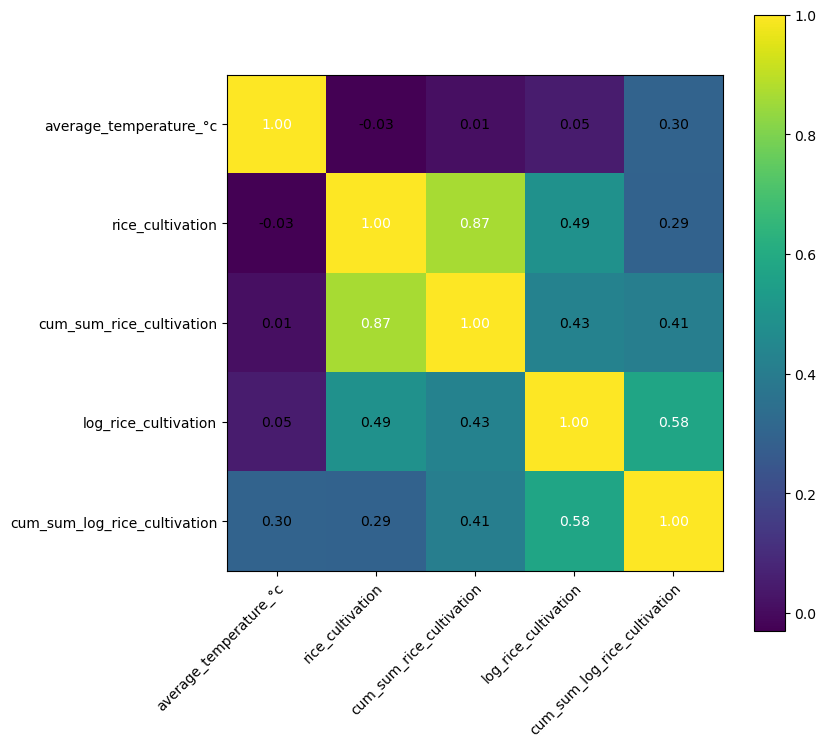

In [9]:
cols = ['average_temperature_°c','rice_cultivation', 'cum_sum_rice_cultivation', 'log_rice_cultivation','cum_sum_log_rice_cultivation']

cm = train[cols].corr().values
hm = heatmap(
    cm,
    row_names=cols,
    column_names=cols,
    figsize=(8, 8)
)

#### Drained Organic Soils

Cumulative sum of log of drained organice soil emissions has highest correlation with average temperature change. 

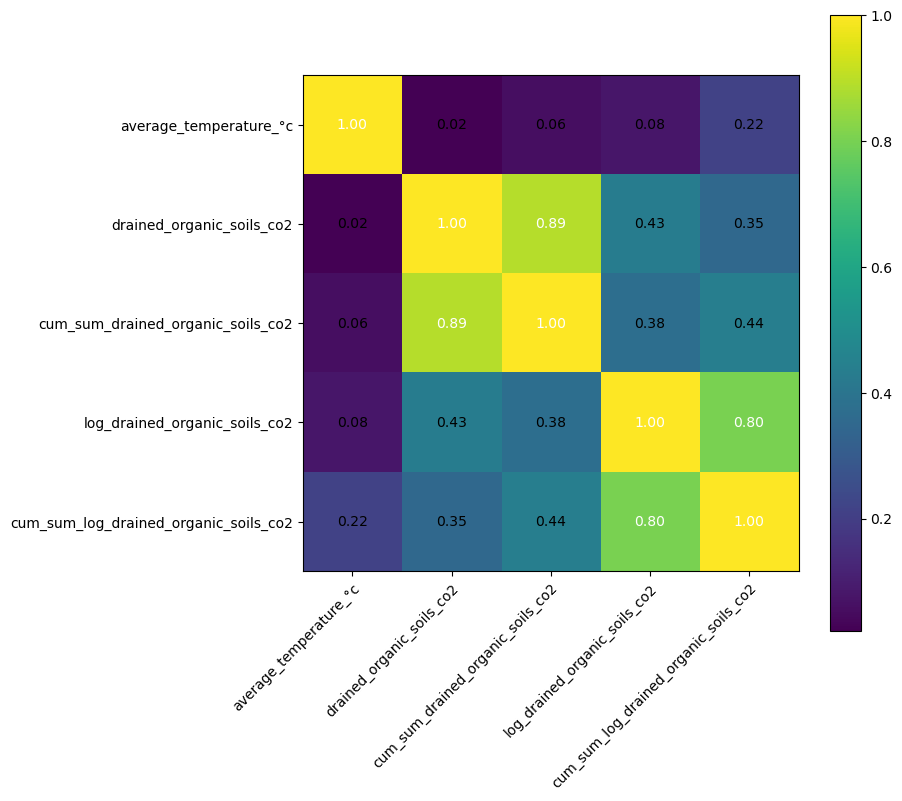

In [10]:
cols = ['average_temperature_°c', 'drained_organic_soils_co2', 'cum_sum_drained_organic_soils_co2', 'log_drained_organic_soils_co2','cum_sum_log_drained_organic_soils_co2']

cm = train[cols].corr().values
hm = heatmap(
    cm,
    row_names=cols,
    column_names=cols,
    figsize=(8, 8)
)

#### Net Forest Conversion

Cumulative sum of log of net forest conversion emissions has highest correlation with average temperature change. 

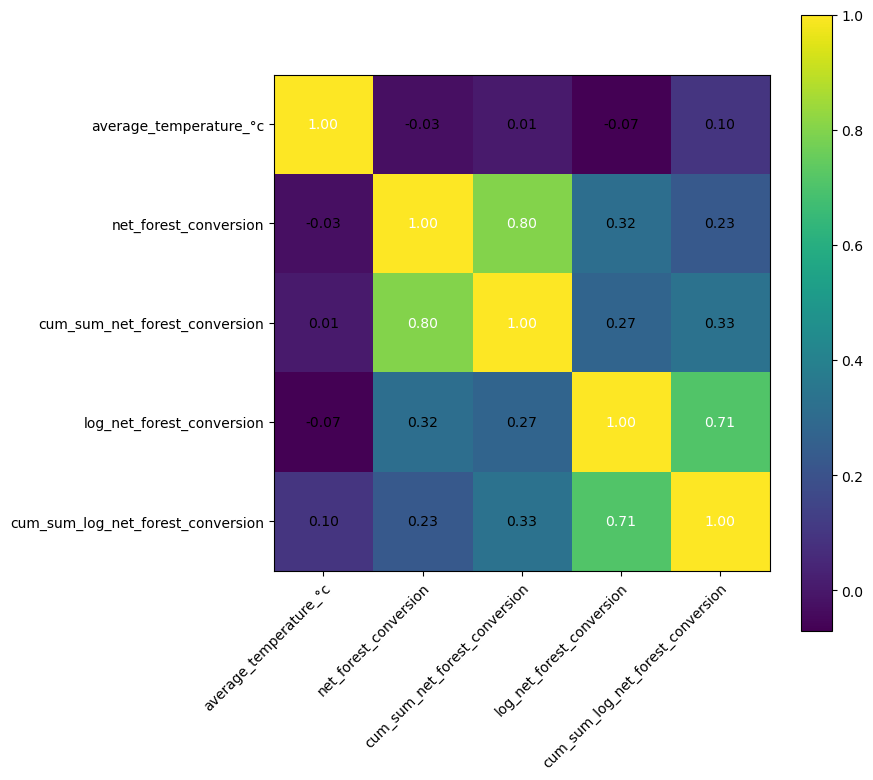

In [11]:
cols = ['average_temperature_°c','net_forest_conversion', 'cum_sum_net_forest_conversion', 'log_net_forest_conversion','cum_sum_log_net_forest_conversion']

cm = train[cols].corr().values
hm = heatmap(
    cm,
    row_names=cols,
    column_names=cols,
    figsize=(8, 8)
)

#### Fires

Cumulative sum of log of fire emissions has highest correlation with average temperature change. 

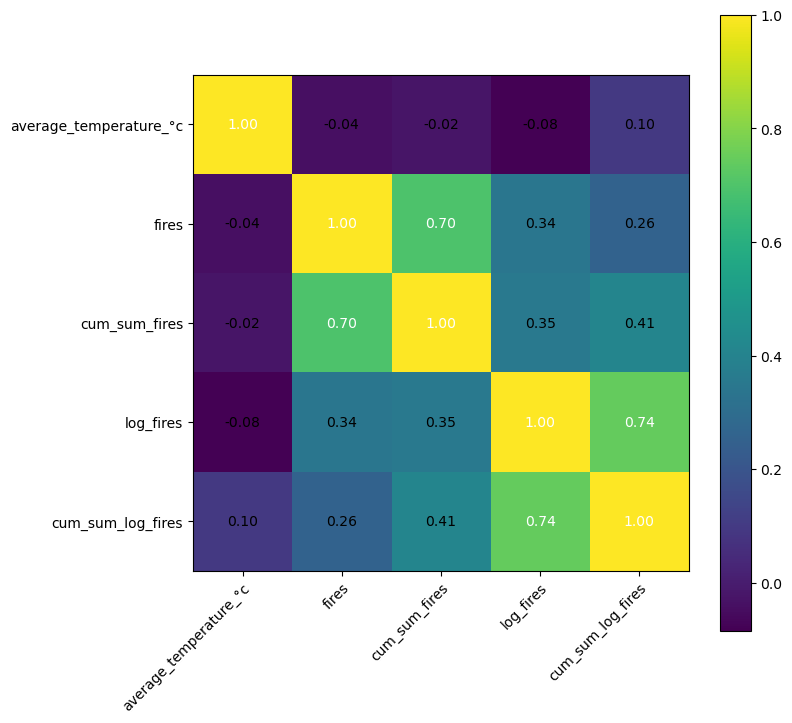

In [12]:
cols = ['average_temperature_°c','fires', 'cum_sum_fires', 'log_fires','cum_sum_log_fires']

cm = train[cols].corr().values
hm = heatmap(
    cm,
    row_names=cols,
    column_names=cols,
    figsize=(8, 8)
)

#### Manure Management

Cumulative sum of log of manure management emissions has highest correlation with average temperature change. 

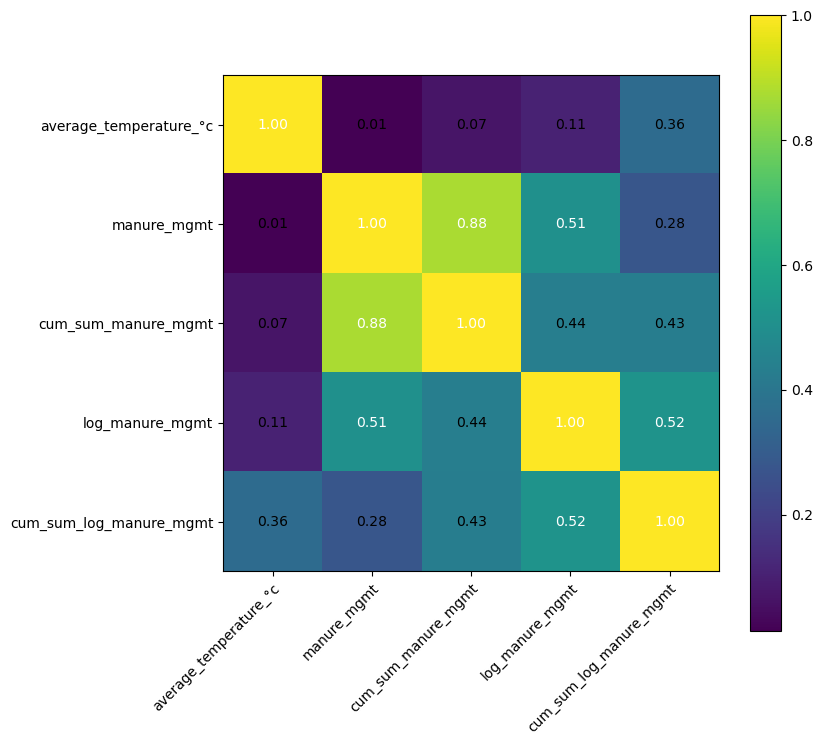

In [13]:
cols = ['average_temperature_°c','manure_mgmt', 'cum_sum_manure_mgmt', 'log_manure_mgmt','cum_sum_log_manure_mgmt']

cm = train[cols].corr().values
hm = heatmap(
    cm,
    row_names=cols,
    column_names=cols,
    figsize=(8, 8)
)

#### Food Systems

Cumulative sum of log of food systems emissions has highest correlation with average temperature change. 

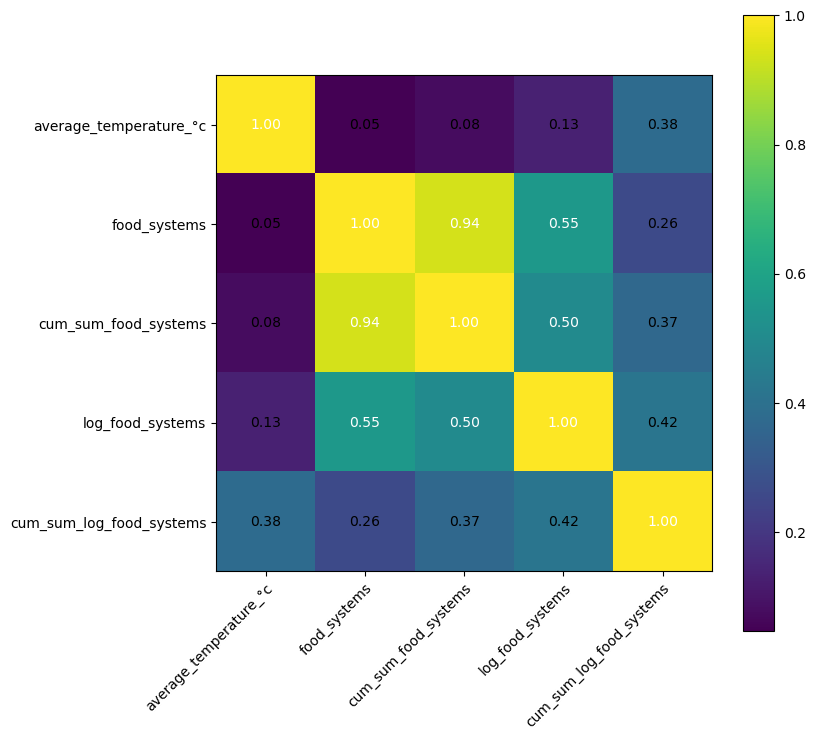

In [14]:
cols = ['average_temperature_°c','food_systems', 'cum_sum_food_systems', 'log_food_systems','cum_sum_log_food_systems']

cm = train[cols].corr().values
hm = heatmap(
    cm,
    row_names=cols,
    column_names=cols,
    figsize=(8, 8)
)

#### IPPU

Cumulative sum of log of IPPU emissions has highest correlation with average temperature change. 

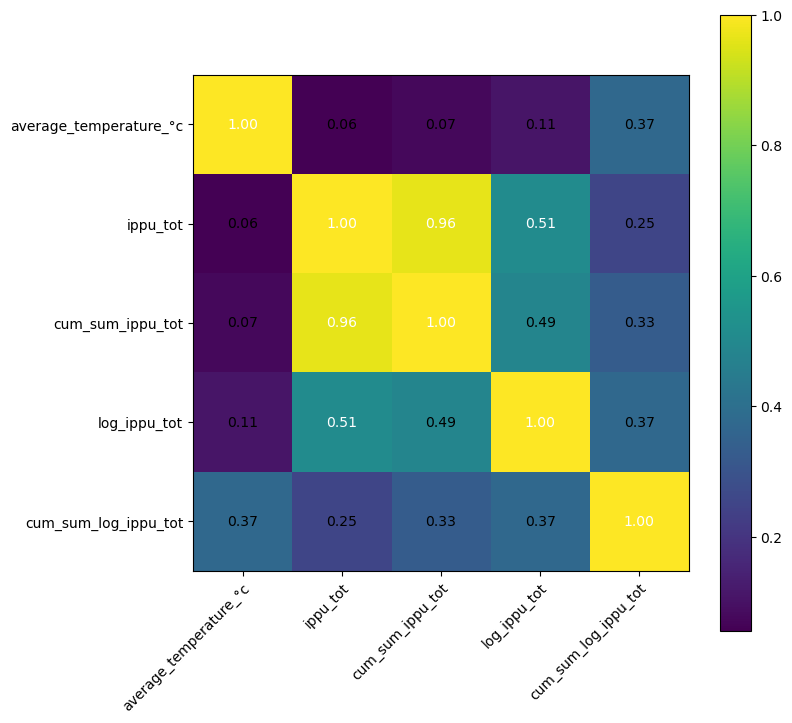

In [16]:
cols = ['average_temperature_°c', 'ippu_tot', 'cum_sum_ippu_tot', 'log_ippu_tot','cum_sum_log_ippu_tot']
cm = train[cols].corr().values
hm = heatmap(
    cm,
    row_names=cols,
    column_names=cols,
    figsize=(8, 8)
)

#### On Farm Energy Use

Cumulative sum of log of on farm energy use emissions has highest correlation with average temperature change. 

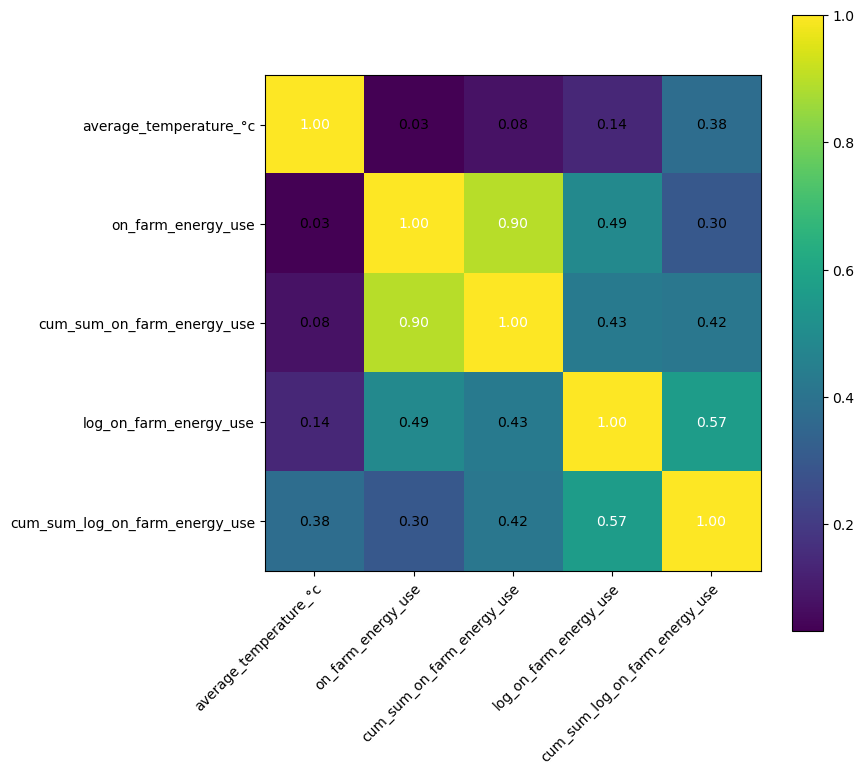

In [17]:
cols = ['average_temperature_°c','on_farm_energy_use', 'cum_sum_on_farm_energy_use', 'log_on_farm_energy_use','cum_sum_log_on_farm_energy_use']

cm = train[cols].corr().values
hm = heatmap(
    cm,
    row_names=cols,
    column_names=cols,
    figsize=(8, 8)
)

#### Forestland

Cumulative sum of forestland emissions has highest correlation with average temperature change (expect this to be a negative correlation since forestland sequesters carbon). 

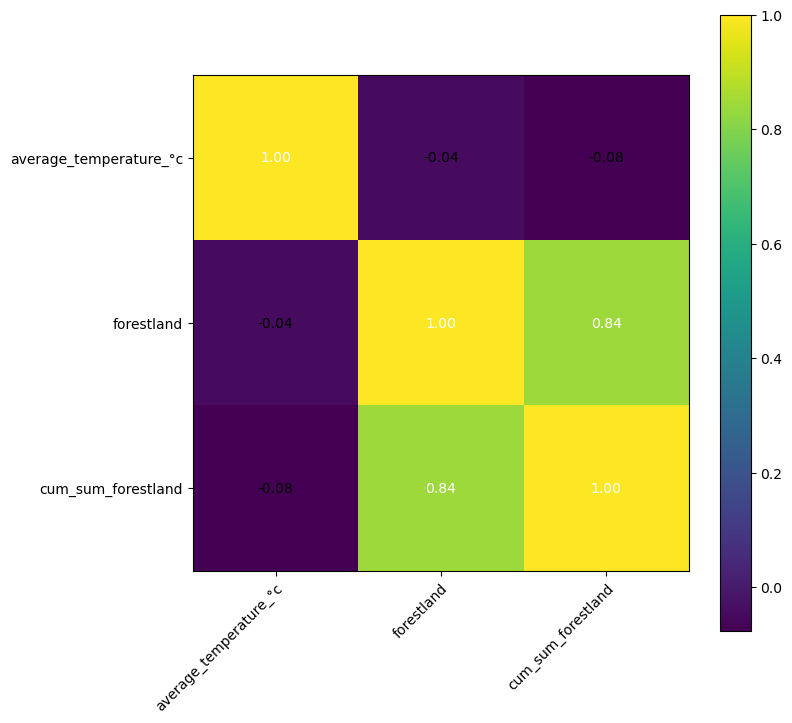

In [17]:
cols = ['average_temperature_°c','forestland','cum_sum_forestland']

cm = train[cols].corr().values
hm = heatmap(
    cm,
    row_names=cols,
    column_names=cols,
    figsize=(8, 8)
)

#### Total Emissions

Cumulative sum of total emissions has highest correlation with average temperature change, but overall fairly low correlation. 

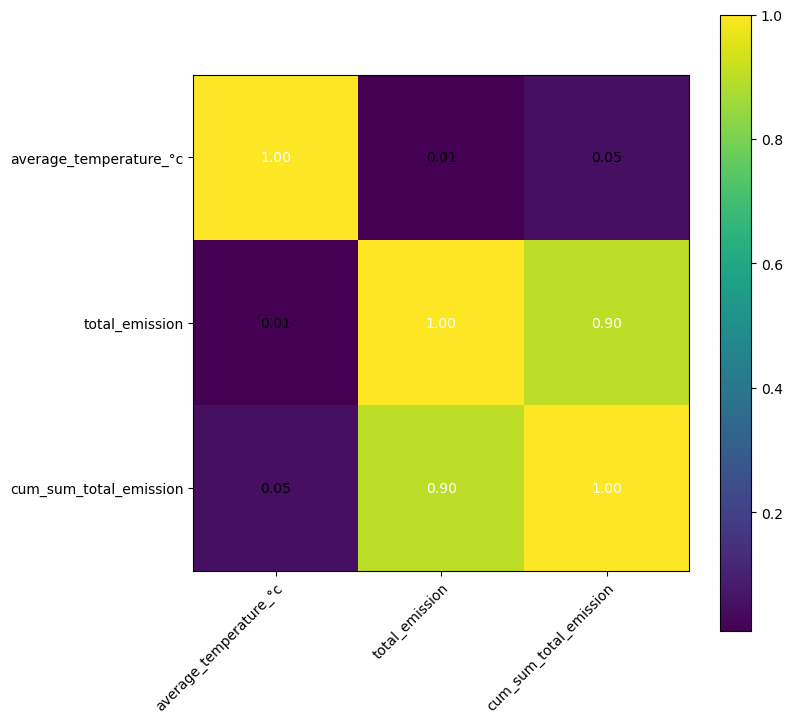

In [18]:
cols = ['average_temperature_°c','total_emission','cum_sum_total_emission']

cm = train[cols].corr().values
hm = heatmap(
    cm,
    row_names=cols,
    column_names=cols,
    figsize=(8, 8)
)

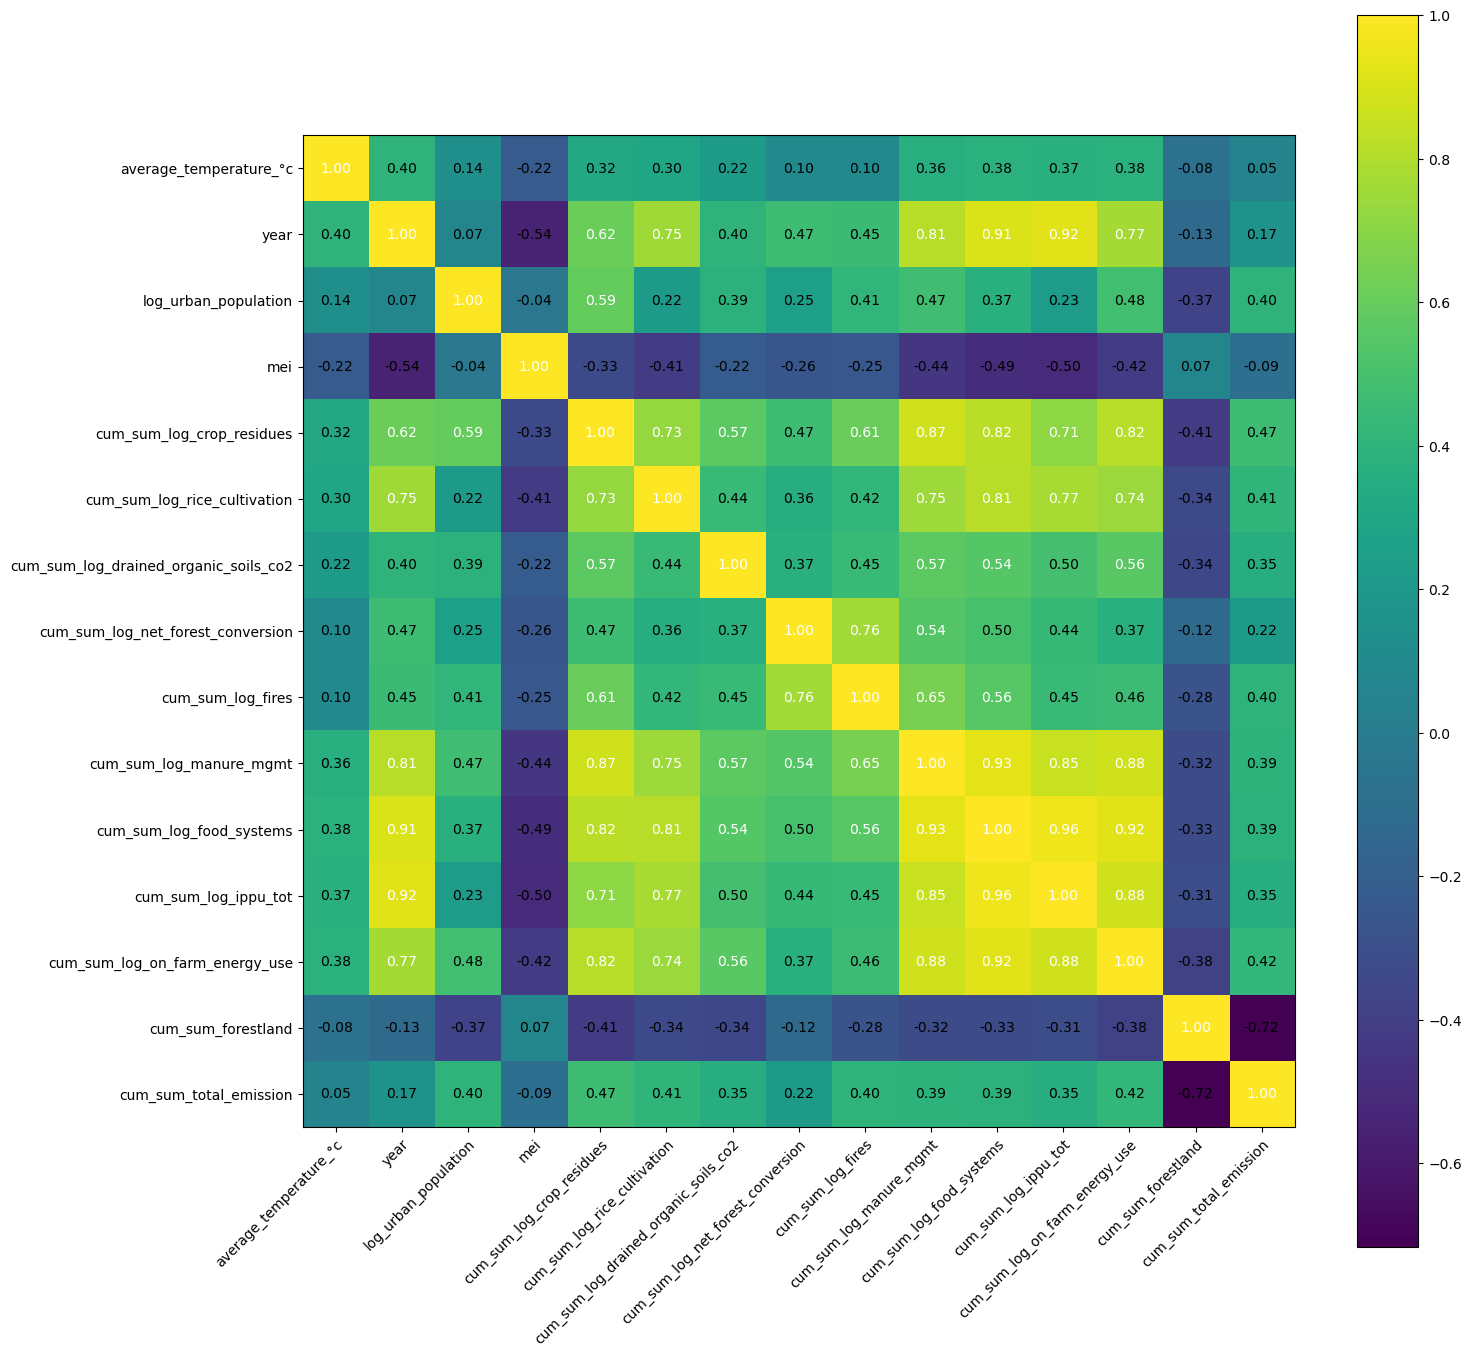

In [19]:
cols = ['average_temperature_°c','year','log_urban_population','mei','cum_sum_log_crop_residues','cum_sum_log_rice_cultivation',
        'cum_sum_log_drained_organic_soils_co2','cum_sum_log_net_forest_conversion','cum_sum_log_fires','cum_sum_log_manure_mgmt','cum_sum_log_food_systems','cum_sum_log_ippu_tot',
        'cum_sum_log_on_farm_energy_use','cum_sum_forestland','cum_sum_total_emission']
cm = train[cols].corr().values
hm = heatmap(
    cm,
    row_names=cols,
    column_names=cols,
    figsize=(16, 16)
)

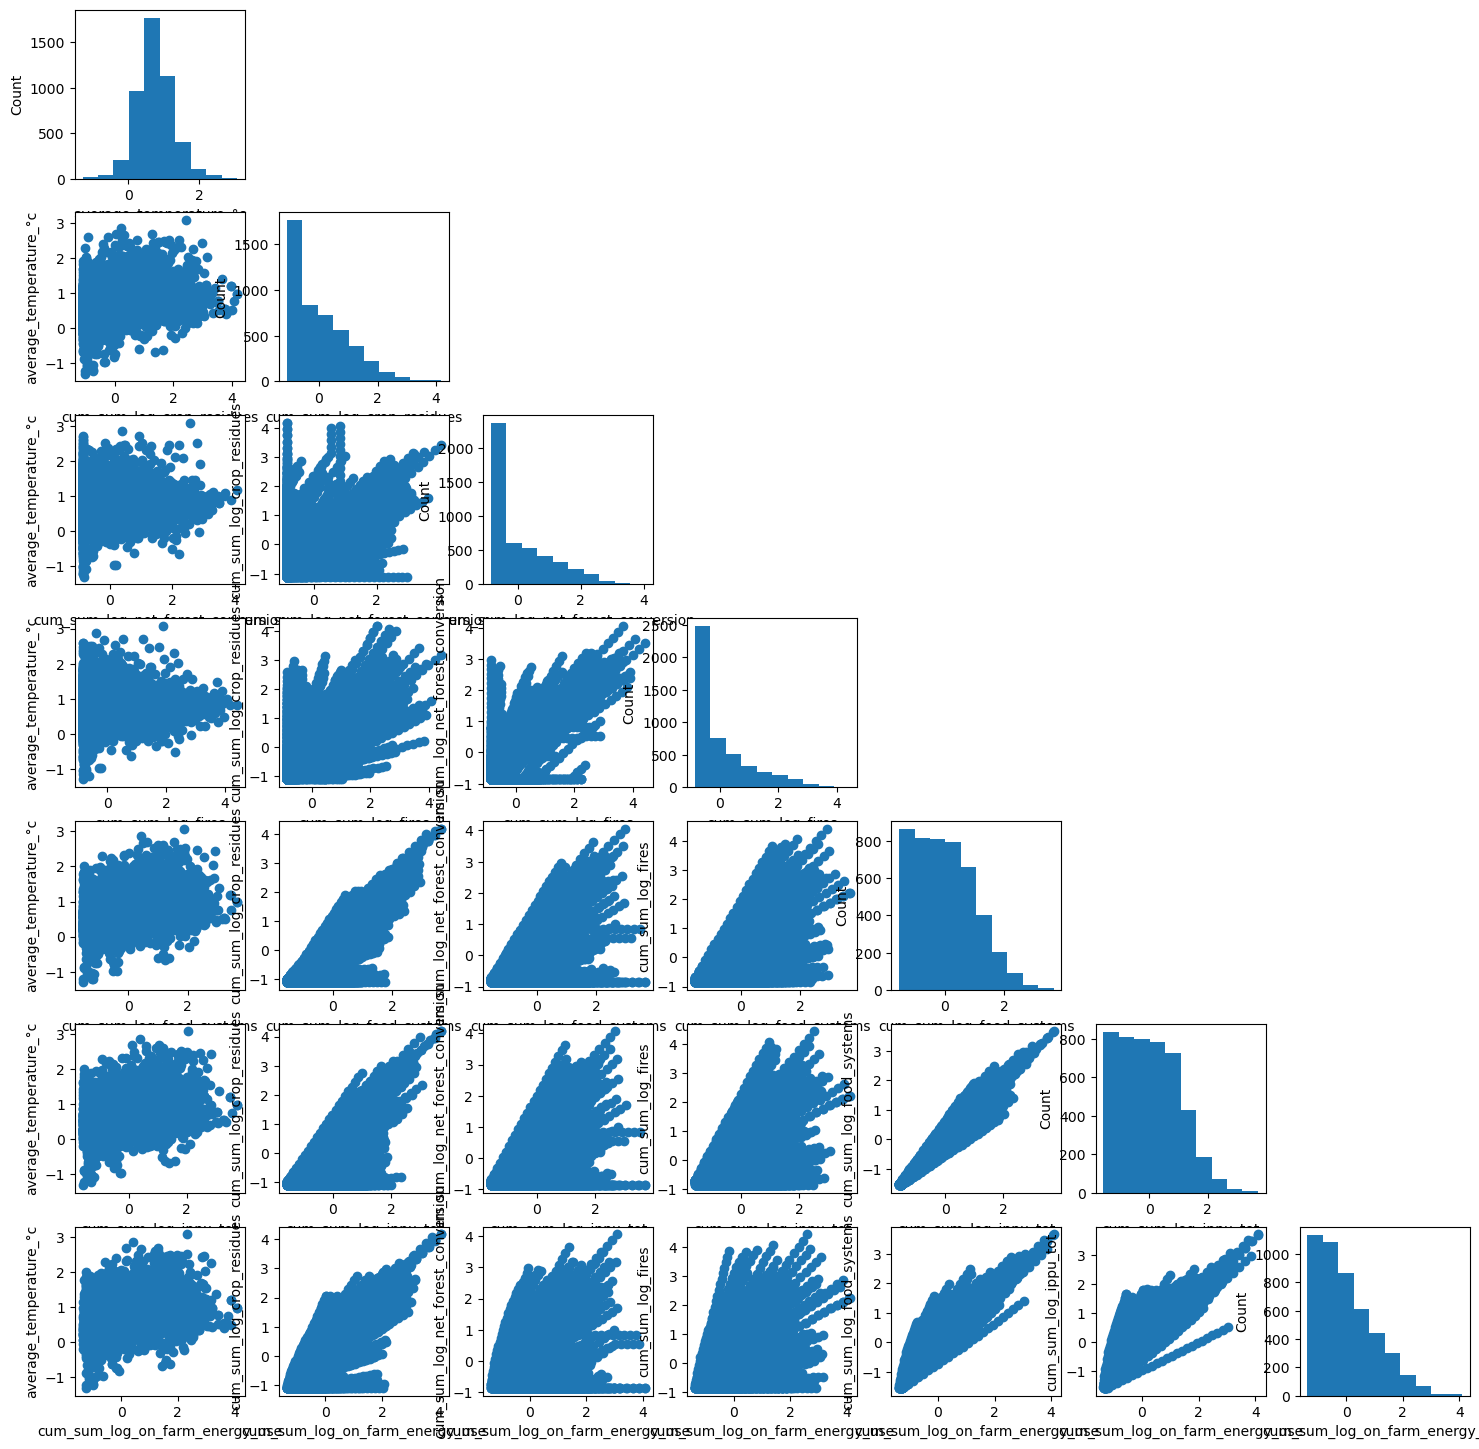

In [20]:
feat = ['average_temperature_°c','cum_sum_log_crop_residues','cum_sum_log_net_forest_conversion','cum_sum_log_fires','cum_sum_log_food_systems','cum_sum_log_ippu_tot','cum_sum_log_on_farm_energy_use']

scatterplotmatrix(
    train[feat].values,
    names=feat,
    figsize=(18,18), alpha=1
);